<a href="https://colab.research.google.com/github/EdwinZhanCN/Lab-1/blob/main/02_modeling_and_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install kagglehub pandas numpy matplotlib seaborn scikit-learn

## Dataset Preparation
First,we identify all columns and drop columns with no enough rows. And we drop all rows that has no enough columns.

In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("kemical/kickstarter-projects")
csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df=pd.read_csv(os.path.join(path, csv_file))


Using Colab cache for faster access to the 'kickstarter-projects' dataset.


In [ ]:
# Identify all unique columns
unique_columns = []
for column in df.columns:
    unique_columns.append(column)
print(unique_columns)

# Drop unsatisified columns
df_clean = df.drop(columns=['ID', 'usd_pledged_real', 'usd_goal_real'])
# Drop all rows that does not have 'usd pledged'
df_leak = df_clean.dropna(subset=['usd pledged']).copy()
display(df_leak.head(5))

['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']


,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0


### Identify Leakage

#### Name Leakage
The name column here behaves like a unique identifier like ID. In the context that we're unable to analyze the name semantically, I decided to map the `'name'` to `'name_length'`

In [ ]:
# Replace name with name_length, calculate for each
df_leak['name_length'] = df_leak['name'].str.len()
df_leak.drop(columns=['name'], inplace=True)
final_columns = []
for column in df_leak.columns:
    final_columns.append(column)
print(final_columns)
display(df_leak.head(5))

['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'name_length']


,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,name_length
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,31.0
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,45.0
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,14.0
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,49.0
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,58.0


### EDA

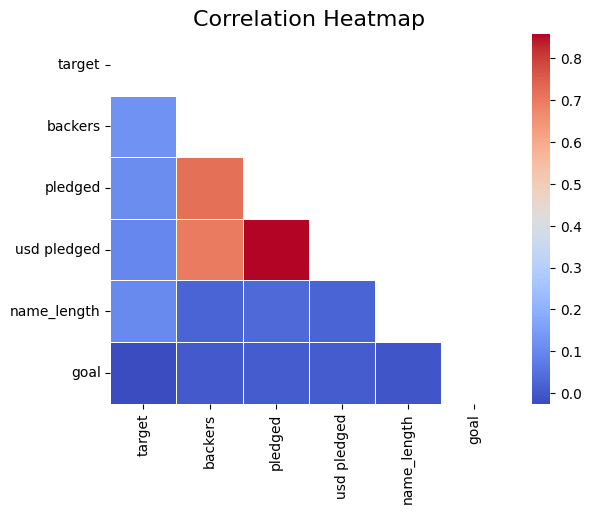

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


valid_state = ['successful', 'failed']
df_eda = df_leak[df_leak['state'].isin(valid_state)].copy()
# Replace valid state with boolean flag
df_eda['target'] = df_eda['state'].apply(lambda x: 1 if x == 'successful' else 0)

leakage_candidate = ['target', 'backers', 'pledged', 'usd pledged', 'name_length', 'goal']
corr_matrix = df_eda[leakage_candidate].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


#### Leakage

From the heatmap above, we can see flagged leakage columns are pledged, usd pledge and backers. A interesting thing here is they both have weak correlation with target, this is abnormal but can be explained. For example, a high pledged amount can still result in failure if the goal is extremely high. And both three features are unknown at the time of project launch, so they're both post-outcome features. So I decide to drop them.

Another leakage would occur is the time, we cannot use past data to predict the future data, but thankfully, we can use the deadline and launched to calculate the duration of those kickstarter projects.

Moreover, to enrich the features, I also introduce launched month and year for seasonal check.

In [ ]:

# Drop 'pledged, usd pledged, backers' and wasted 'state'
df_valid = df_eda.drop(columns=['pledged', 'usd pledged', 'backers', 'state']).copy()
df_valid['deadline'] = pd.to_datetime(df_valid['deadline'])
df_valid['launched'] = pd.to_datetime(df_valid['launched'])

df_valid['duration'] = (df_valid['deadline'] - df_valid['launched']).dt.days

df_valid['launch_month'] = df_valid['launched'].dt.month
df_valid['launch_year'] = df_valid['launched'].dt.year

unique_columns = []
for column in df_valid.columns:
    unique_columns.append(column)
print(unique_columns)

display(df_valid.head(5))

['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'country', 'name_length', 'target', 'duration', 'launch_month', 'launch_year']


,category,main_category,currency,deadline,goal,launched,country,name_length,target,duration,launch_month,launch_year
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,GB,31.0,0,58,8,2015
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,US,45.0,0,59,9,2017
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,US,14.0,0,44,1,2013
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,US,49.0,0,29,3,2012
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,US,20.0,1,34,2,2016


### Time-based Split

First, we drop the NaN data, then, sort the data from by lauch_year and lauch_month to prevent them from time leakage. drop the leakage data like deadline, launched.

In [ ]:
df_safe = df_valid.sort_values(['launch_year', 'launch_month'])
df_safe = df_safe.dropna()

X = df_safe.drop(columns=['deadline', 'launched', 'target'])
y = df_safe['target']

split_ratio = 0.8
split_index = int(len(df_safe) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


#### Learning pipeline

So obviously, we have two different types of feature, one is numerical and another is text based. And we use standard scaler to prepare data that training on Guassian distribution, and use OneHotEncoder and handle_unknown flag to help model ignore the test data they've never saw before.



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB

numeric_features = ['goal', 'name_length', 'duration', 'launch_month', 'launch_year']
text_features = ['category', 'main_category', 'currency', 'country']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), text_features)
    ]
)


base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GaussianNB())
])

base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['goal', 'name_length',
                                                   'duration', 'launch_month',
                                                   'launch_year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category', 'main_category',
                                                   'currency', 'country'])])),
                ('model', GaussianNB())])

### Evalution

We use F1-score and Confusion matrix

F1-Score: 0.5915

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.52      0.60     38790
           1       0.51      0.71      0.59     27503

    accuracy                           0.60     66293
   macro avg       0.61      0.61      0.60     66293
weighted avg       0.63      0.60      0.60     66293



<Figure size 800x600 with 0 Axes>

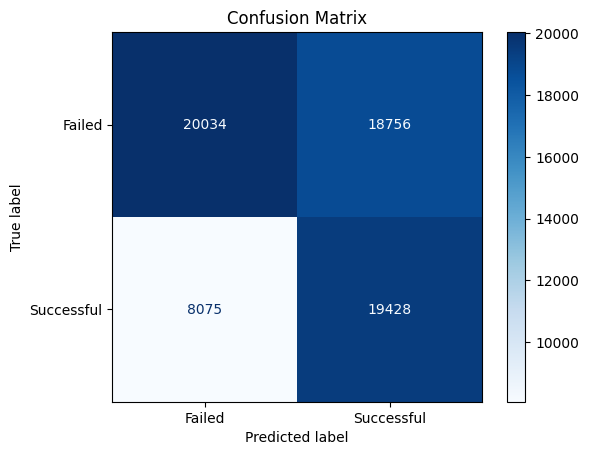

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = base_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Failed', 'Successful'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

#### SVM

For SVM, we're continue using our ColumnTransformer

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SGDClassifier(loss='hinge',class_weight='balanced', random_state=42))
])

param_grid = {
    'model__alpha': [1e-5, 1e-4, 1e-3],
    'model__penalty': ['l2'],
}

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_

#### Calibration
Since we're using SVM to do classification, of course we want a probability after calibration.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

best_pred = best_svm.predict(X_test)
f1_best = f1_score(y_test, best_pred >= 0.5)
print(f"F1-Score (Best Model): {f1_best:.4f}")
print(classification_report(y_test, best_pred >= 0.5))

calibrated_svm = CalibratedClassifierCV(best_svm, method='sigmoid', cv=3)
calibrated_svm.fit(X_train, y_train)
calibrated_pred_probs = calibrated_svm.predict_proba(X_test)[:, 1]

f1_calib = f1_score(y_test, calibrated_pred_probs >= 0.5)
print(f"F1-Score (Calibrated): {f1_calib:.4f}")
print(classification_report(y_test, calibrated_pred_probs >= 0.5))


F1-Score (Best Model): 0.5932
              precision    recall  f1-score   support

           0       0.71      0.67      0.69     38790
           1       0.57      0.62      0.59     27503

    accuracy                           0.65     66293
   macro avg       0.64      0.64      0.64     66293
weighted avg       0.65      0.65      0.65     66293

F1-Score (Calibrated): 0.0678
              precision    recall  f1-score   support

           0       0.59      0.99      0.74     38790
           1       0.82      0.04      0.07     27503

    accuracy                           0.60     66293
   macro avg       0.71      0.52      0.41     66293
weighted avg       0.69      0.60      0.46     66293



<Figure size 800x600 with 0 Axes>

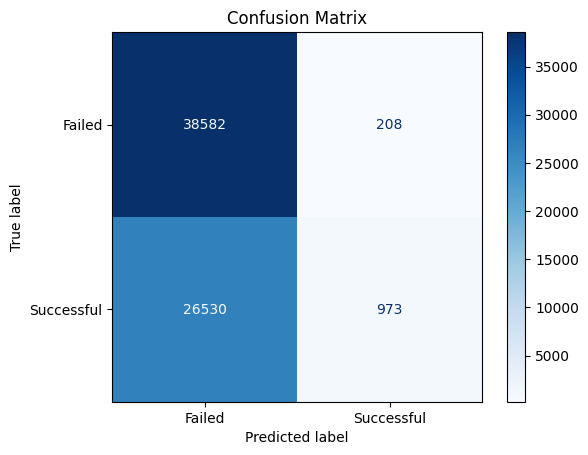

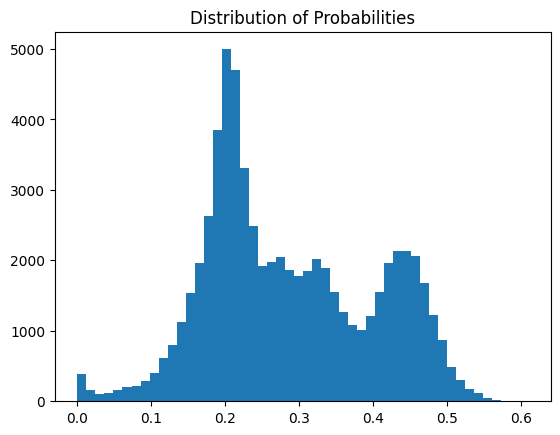

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

preds = (calibrated_pred_probs >= 0.5).astype(int)
cm = confusion_matrix(y_test, preds)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Failed', 'Successful'])
plt.figure(figsize=(8, 6))
disp_svm.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

plt.hist(calibrated_pred_probs, bins=50)
plt.title("Distribution of Probabilities")
plt.show()

### SVM Results
I use two different SGD variants with following settings:
- Hinge loss, Alpha: [0.0001, 0.001, 0.01], threshold 0.5
- Hinge loss (weight balanced), Alpha: [1e-5, 1e-4, 1e-3], threshold 0.5

Compare to GaussianNB model I used in last lab section, the best F1-score I hit for SGD model is the setting:
-  Hinge loss (weight balanced), Alpha: [1e-5, 1e-4, 1e-3], threshold 0.5
- F1 score 0.5932

While the Gussian naive bayes model get
- F1 socre 0.5915

They are very close. I recorded the SGD Calibrated in following two settings:

- Hinge loss, Alpha: [0.0001, 0.001, 0.01], threshold 0.5
- Hinge loss (weight balanced), Alpha: [1e-5, 1e-4, 1e-3], threshold 0.5

But the F1-score is very low when weighted balanced is enabled, it's only 0.0678. Since sigmoid calibration causes probability collapse in the current feature space (Recall drops from 0.62 to 0.04), I choose to use raw decision scores for threshold optimization.

So I decide to skip the calibration before decision justification.

#### Decision Justification

Therefore, I adopted a 10:1 cost ratio penalizing False Positives more heavily. Despite this conservative cost structure, our SVM model yielded an optimal threshold of 0.01, which is significantly lower than the default 0.5. This shows model's severely unconfident probability distribution. So maybe it is actually good to set the decision boundary to 0.01 to this unconfident model.

In [ ]:
import numpy as np

thresholds = np.linspace(0, 1, 100)
costs = []

for t in thresholds:
    preds = (best_pred >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = (fp * 10) + (fn * 1)
    costs.append(total_cost)

print(f"Total Cost: {np.min(costs)}")
best_threshold = thresholds[np.argmin(costs)]
print(f"Optimal Threshold: {best_threshold:.2f}")

Total Cost: 137368
Optimal Threshold: 0.01


<Figure size 800x600 with 0 Axes>

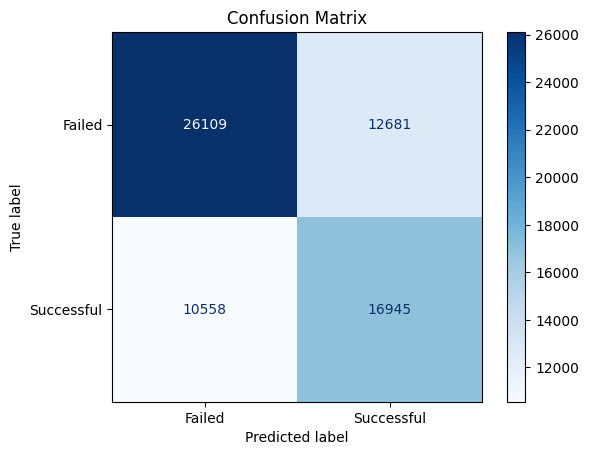

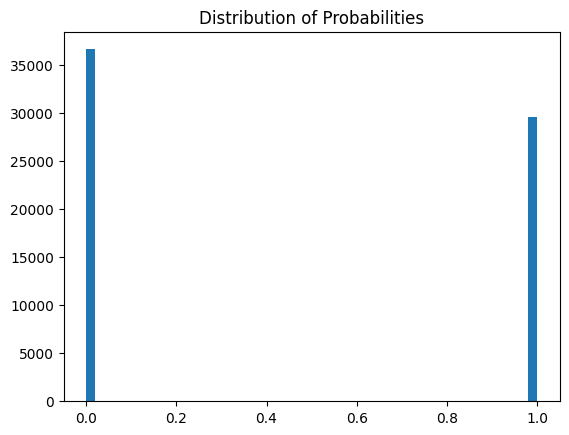

In [ ]:
preds_best = (best_pred >= 0.01).astype(int)
cm = confusion_matrix(y_test, preds_best)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Failed', 'Successful'])
plt.figure(figsize=(8, 6))
disp_svm.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

plt.hist(best_pred, bins=50)
plt.title("Distribution of Probabilities")
plt.show()